In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. 데이터셋 가져오기
    torchvision에서 [-1, 1]로 정규화해 가져오기(MNIST)
    (28x28 픽셀 이미지)

In [7]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]) #mean=0.1307, standard deviation=0.3081

trainset=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader=torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

testloader=torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')



## Training data 출력해보기

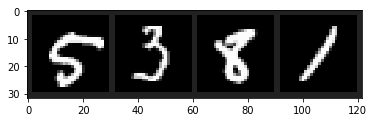

    5     3     8     1


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img*0.3081 +0.1307 # unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter=iter(trainloader)
images, labels=dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. CNN 정의하기

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # define convolution layers and pooling function
        self.conv1=nn.Conv2d(1, 10, 5)  # 1 input image channel,  10 output channels, 5x5 square convolution
        self.pool=nn.MaxPool2d(2, 2)  # maxpooling over a (2, 2) window
        self.conv2=nn.Conv2d(10, 20, 5)  # 10 input channels, 20 output channels, 5x5 square convolution
        
        # define linear layers including output layer
        self.fc1=nn.Linear(20*4*4, 150)
        self.fc2=nn.Linear(150, 90)  # size of input=150, size of output=90
        self.fc3=nn.Linear(90, 10)  # size of input=90, size of output=10=number of classes
        
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))  # Conv Layer1-> ReLu -> Max Pooling
        x=self.pool(F.relu(self.conv2(x)))  # Conv Layer2-> ReLu -> Max Pooling
        x=x.view(-1, 20*4*4)  # reshape tensor for relu
        x=F.relu(self.fc1(x))  # Linear Layer1-> ReLu
        x=F.relu(self.fc2(x))  # Linear Layer2-> ReLu
        x=self.fc3(x)  # Output Layer
        return x  # return output
    
net=Net()
        

# 3. Loss function과 Optimizer 정의하기
    Loss function: Classification Cross Entropy Loss
    Optimizer: SGD with momentum

In [13]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # parameters of previously declared net

# 4. Network 학습시키기

In [14]:
for epoch in range(3):  # loop
    
    running_loss=0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels=data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs=net(inputs)  # forward propagation
        loss=criterion(outputs, labels)  # compute loss
        loss.backward()  # backward propagation (compute gradient)
        optimizer.step()  # update parameters
        
        # print statistics
        running_loss+=loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss/2000))
            running_loss=0.0
            
print('Finished Training')

[1,  2000] loss: 0.785
[1,  4000] loss: 0.186
[1,  6000] loss: 0.133
[1,  8000] loss: 0.118
[1, 10000] loss: 0.099
[1, 12000] loss: 0.079
[1, 14000] loss: 0.080
[2,  2000] loss: 0.057
[2,  4000] loss: 0.058
[2,  6000] loss: 0.048
[2,  8000] loss: 0.058
[2, 10000] loss: 0.057
[2, 12000] loss: 0.053
[2, 14000] loss: 0.046
[3,  2000] loss: 0.036
[3,  4000] loss: 0.031
[3,  6000] loss: 0.037
[3,  8000] loss: 0.038
[3, 10000] loss: 0.045
[3, 12000] loss: 0.034
[3, 14000] loss: 0.034
Finished Training


# 5. Test data에 성능 평가하기

## Test data 이미지 출력해보기

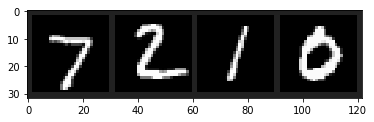

GroundTruth:  7 2 1 0


In [15]:
dataiter=iter(testloader)
images, labels=dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes [labels[j]] for j in range(4)))

In [16]:
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()
        
print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

Accuracy of the network on the test images: 98 %


In [18]:
class_correct=list(0. for i in range(10))  # number of correctly classified samples for each class
class_total=list(0. for i in range(10))  # total number of samples for each class
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=net(images)
        _, predicted=torch.max(outputs, 1)
        c=(predicted == labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
            
for i in range(10):
    print('Accuracy of %s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of 0 : 99 %
Accuracy of 1 : 99 %
Accuracy of 2 : 99 %
Accuracy of 3 : 98 %
Accuracy of 4 : 98 %
Accuracy of 5 : 98 %
Accuracy of 6 : 98 %
Accuracy of 7 : 98 %
Accuracy of 8 : 99 %
Accuracy of 9 : 97 %
